In [0]:
!pip install -q --upgrade tensorflow #switch from tensorflow v1 to v2
import tensorflow as tf
print(tf.__version__)

In [0]:
!pip install -q Keras==2.3.0

In [0]:
import nltk
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
nltk.download('punkt') 
nltk.download('wordnet')
import json
import pickle

import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import SGD
import random

In [0]:
words = []
classes = []
documents = []
ignore_words = ['?', '!']
data = open('/content/drive/My Drive/intents.json').read()
intents = json.loads(data)

In [6]:
print(intents)

{'intents': [{'tag': 'greeting', 'patterns': ['Hi there', 'How are you', 'Is anyone there?', 'Hey', 'Hola', 'Hello', 'Good day'], 'responses': ['Hello, thanks for asking', 'Good to see you again', 'Hi there, how can I help?'], 'context': ['']}, {'tag': 'goodbye', 'patterns': ['Bye', 'See you later', 'Goodbye', 'Nice chatting to you, bye', 'Till next time'], 'responses': ['See you!', 'Have a nice day', 'Bye! Come back again soon.'], 'context': ['']}, {'tag': 'thanks', 'patterns': ['Thanks', 'Thank you', "That's helpful", 'Awesome, thanks', 'Thanks for helping me'], 'responses': ['Happy to help!', 'Any time!', 'My pleasure'], 'context': ['']}, {'tag': 'noanswer', 'patterns': [], 'responses': ["Sorry, can't understand you", 'Please give me more info', 'Not sure I understand'], 'context': ['']}, {'tag': 'options', 'patterns': ['How you could help me?', 'What you can do?', 'What help you provide?', 'How you can be helpful?', 'What support is offered'], 'responses': ['I can guide you through

In [0]:
for intent in intents['intents']:
    for pattern in intent['patterns']: #words to say or input

        #tokenize each word
        w = nltk.word_tokenize(pattern)
        words.extend(w)
        #add documents in the corpus
        documents.append((w, intent['tag']))

        #add to our classes list
        if intent['tag'] not in classes:
            classes.append(intent['tag'])

>Now we will lemmatize each word and remove duplicate words from the list. 

>Lemmatizing is the process of converting a word into its lemma form and then creating a pickle file to store the python objects which we will use while predicting.

In [8]:
#lemmatize, lower each word and remove duplicates
words = [lemmatizer.lemmatize(w.lower()) for w in words if w not in ignore_words] #if it's(word) not in our list of ignored words, then perform lemmatization
words = sorted(list(set(words))) #set() will help in removing any duplicates

#sort classes
classes = sorted(list(set(classes)))

#documents = combination between patterns(w- what we tell the bot) and intents[tags]
print(len(documents), 'documents')

#classes = intents('tags)
print(len(classes), 'classes', classes)

#words = all words, vocalbulary
print(len(words), 'unique lemmatiazed words', words)

pickle.dump(words,open('words.pkl', 'wb'))
pickle.dump(classes,open('classes.pkl', 'wb'))


47 documents
9 classes ['adverse_drug', 'blood_pressure', 'blood_pressure_search', 'goodbye', 'greeting', 'hospital_search', 'options', 'pharmacy_search', 'thanks']
88 unique lemmatiazed words ["'s", ',', 'a', 'adverse', 'all', 'anyone', 'are', 'awesome', 'be', 'behavior', 'blood', 'by', 'bye', 'can', 'causing', 'chatting', 'check', 'could', 'data', 'day', 'detail', 'do', 'dont', 'drug', 'entry', 'find', 'for', 'give', 'good', 'goodbye', 'have', 'hello', 'help', 'helpful', 'helping', 'hey', 'hi', 'history', 'hola', 'hospital', 'how', 'i', 'id', 'is', 'later', 'list', 'load', 'locate', 'log', 'looking', 'lookup', 'management', 'me', 'module', 'nearby', 'next', 'nice', 'of', 'offered', 'open', 'patient', 'pharmacy', 'pressure', 'provide', 'reaction', 'related', 'result', 'search', 'searching', 'see', 'show', 'suitable', 'support', 'task', 'thank', 'thanks', 'that', 'there', 'till', 'time', 'to', 'transfer', 'up', 'want', 'what', 'which', 'with', 'you']


###**Creating training and testing data**

In [0]:
#create our training data
training = []

#create an empty array for our output
output_empty = [0] * len(classes) #[0, 0, 0, 0, 0, 0, 0, 0, 0]

#training set, bag of words for each sentence
for doc in documents:
    #initialize our bag of words
    bag = []
    #list of tokenized words for the pattern
    pattern_words = doc[0]
    #lemmatize each word - create base word, in attempt to represent related words
    pattern_words = [lemmatizer.lemmatize(word.lower()) for word in pattern_words]
    # create our bag of words array with 1, if word match found in current pattern
for w in words:
    bag.append(1) if w in pattern_words else bag.append(0)
    # output is a '0' for each tag and '1' for current tag (for each pattern)
    output_row = list(output_empty)
    output_row[classes.index(doc[1])] = 1
    training.append([bag, output_row])
# shuffle our features and turn into np.array
random.shuffle(training)
training = np.array(training)
# create train and test lists. X - patterns, Y - intents
train_x = list(training[:,0])
train_y = list(training[:,1])


###**Build the model**

In [10]:
# Create model - 3 layers. First layer 128 neurons, second layer 64 neurons and 3rd output layer contains number of neurons
# equal to number of intents to predict output intent with softmax
model = Sequential()
model.add(Dense(128, input_shape=(len(train_x[0]),), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(train_y[0]), activation='softmax'))

# Compile model. Stochastic gradient descent with Nesterov accelerated gradient gives good results for this model
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

#fitting and saving the model 
hist = model.fit(np.array(train_x), np.array(train_y), epochs=200, batch_size=5, verbose=1)

model.save('chatbot_model.h5', hist)
print("model created")

Epoch 1/200
88/88 [==============================] - 0s 1ms/step - loss: 0.6469 - accuracy: 0.8864
Epoch 2/200
88/88 [==============================] - 0s 335us/step - loss: 0.0092 - accuracy: 1.0000
Epoch 3/200
88/88 [==============================] - 0s 268us/step - loss: 6.7441e-04 - accuracy: 1.0000
Epoch 4/200
88/88 [==============================] - 0s 361us/step - loss: 0.0012 - accuracy: 1.0000
Epoch 5/200
88/88 [==============================] - 0s 330us/step - loss: 2.6642e-04 - accuracy: 1.0000
Epoch 6/200
88/88 [==============================] - 0s 312us/step - loss: 8.1539e-04 - accuracy: 1.0000
Epoch 7/200
88/88 [==============================] - 0s 313us/step - loss: 0.0013 - accuracy: 1.0000
Epoch 8/200
88/88 [==============================] - 0s 284us/step - loss: 9.7824e-04 - accuracy: 1.0000
Epoch 9/200
88/88 [==============================] - 0s 320us/step - loss: 0.0073 - accuracy: 1.0000
Epoch 10/200
88/88 [==============================] - 0s 316us/step - loss: 0

###**Load the model**

In [0]:
from keras.models import load_model

regressor = load_model("chatbot_model.h5")

###**Training history visualization**

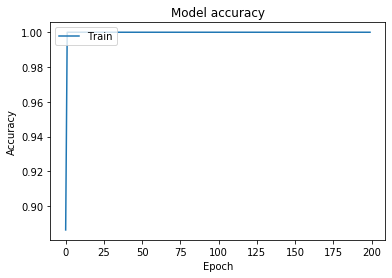

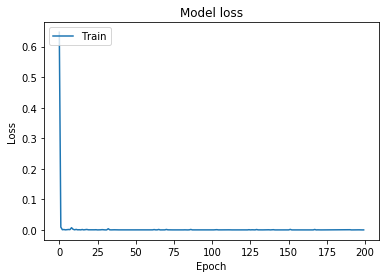

In [13]:
# Plot training & validation accuracy values
plt.plot(hist.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training loss values
plt.plot(hist.history['loss'])

plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

####**Conclusions**
>From the above diagram, the large number of epochs used isn't necesessary. epoch less than 25 would suffice. 

> Generally the model performed well.